<a href="https://colab.research.google.com/github/nverchev/ExplainableVAE/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable VAE


In [69]:
#@title Libraries
#%load_ext autoreload
#%autoreload 2
from google.colab import files as fdownload
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch import optim
from torch.distributions.normal import Normal
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from abc import ABCMeta,abstractmethod
from sklearn.metrics import jaccard_score,confusion_matrix,roc_auc_score

In [71]:
#@title Hyperparameters: { display-mode: "form" }
batch_size =  32#@param {type: "number"}
dim_latent=20 #@param {type: "number"}
initial_learning_rate=0.001 #@param {type: "number"}
weight_decay=0.0000001 #@param {type: "number"}
block = 'mobile' #@param ["mobile","resnet"]


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [72]:
Download = True #@param {type:"boolean"}
transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

pin_memory=torch.cuda.is_available()
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transform), batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,  download=True,
                   transform=transform), batch_size=batch_size, shuffle=True, pin_memory=pin_memory)

In [73]:
#@title Trainer
class Trainer(metaclass=ABCMeta):
    losses=['final_loss']

    def __init__(self,model,version,optim,lr,weight_decay, train_loader, device,**kwargs):
        self.model=model.to(device)
        self.version=version
        self.optimizer=optim(model.parameters(), lr, weight_decay)
        self.device=device
        self.train_loader=train_loader
        self.val_loader=kwargs.get('val_loader',None)
        self.test_loader=kwargs.get('test_loader',None)
        self.train_losses={loss:[] for loss in self.losses}
        self.val_losses={loss:[] for loss in self.losses}
        self.test_losses={loss:[] for loss in self.losses}
        self.epoch=0

    def train(self,num_epoch):
        print('Version ',self.version)
        for _ in range(num_epoch):
            self.epoch+=1
            print('====> Epoch:{}'.format(self.epoch))        
            self.run_session(mode='train')
            if self.val_loader:
              self.run_session(mode='val')
        return
    def test(self):
        print('Version ',self.version)
        return self.run_session(mode='test')

    def auxiliary_inputs(self,img,labels):
      return {}

    def run_session(self,mode=train):
        if mode=='train':
            self.model.train()
            torch.set_grad_enabled(True)
            loader=self.train_loader
            dict_losses= self.train_losses           
        elif mode=='val':
            self.model.eval()
            torch.set_grad_enabled(False)
            loader=self.val_loader
            dict_losses= self.val_losses
        elif mode=='test':
            self.model.eval()
            torch.set_grad_enabled(False)
            loader=self.test_loader
            dict_losses= self.test_losses
            test_img,test_targets,test_outputs= [], [], {}
        else:
          raise ValueError('mode options are "train", "val", "test" ')
        
        len_sess=len(loader.dataset)
        epoch_loss= {loss:0 for loss in  self.losses}
        iterable=tqdm(enumerate(loader),total=len(loader))
        for batch_idx, (img, targets) in iterable:
            
            img, targets = img.to(self.device).float(), targets.to(self.device)
            aux=self.auxiliary_inputs(img,targets)
            outputs =  self.model(img,**aux)
            batch_loss = self.loss(outputs, img, targets)
            for loss in self.losses:
              epoch_loss[loss]+=batch_loss[loss].item()
            if  mode=='train':
              batch_loss['final_loss'].backward()
              self.optimizer.step()
              self.optimizer.zero_grad()
            if  mode=='test':
              for key,value in outputs.items():
                if key not in test_outputs.keys():
                  test_outputs[key]=[]
                test_outputs[key].extend(self.to_numpy(value))
              test_img.extend(self.to_numpy(img))
              test_targets.extend(self.to_numpy(targets))
            if batch_idx % (len(train_loader)//10) == 0 and mode=='train':
                iterable.set_description('Train [{:4d}/{:4d} ]\tLoss {:4f}'.format(
                     batch_idx * loader.batch_size, len_sess,batch_loss['final_loss'].item()))
            if batch_idx == len(train_loader)-1 and mode=='train':
                iterable.set_description('')           
        num_batch=batch_idx+1
        for loss in self.losses:
            dict_losses[loss].append(epoch_loss[loss]/ num_batch)
        print('Average {} losses :'.format(mode))
        for loss in self.losses:
            print('{}: {:.2f}'.format(loss,dict_losses[loss][-1]), end='\t')
        print()
        if  mode=='test':
          return  test_img,test_targets,test_outputs
        else:
          return

    def update_learning_rate(self,new_lr):
        for g in self.optimizer.param_groups:
            g['lr']= new_lr
    @staticmethod
    def to_numpy(tensor):
      return tensor.squeeze().detach().cpu().numpy()

    def load(self, epoch=None):
        raise NotImplementedError

    def save(self,new_version=None):
        raise NotImplementedError

    def paths(self,new_version=None):
        raise NotImplementedError

    def plot_losses(self):
        raise NotImplementedError

    @abstractmethod
    def loss(self,output, img, targets):
        pass



### Training Standard classifier on MNIST

In [74]:
#@title Classifier_nets

class MNISTclassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return {'probs': F.log_softmax(x,dim=1)}
classifier=MNISTclassifier()


In [75]:
#@title Train classifier

class trainer_classifier(Trainer):
    losses=['final_loss','CE']
    def __init__(self, model,version,block_args):
        super().__init__(model,version,**block_args)
    def loss(self, output, img, targets):
        CE=F.nll_loss(output['probs'],targets)
        return {'final_loss':CE,
                'CE':CE}



block_args={
    'optim':optim.Adadelta,
    'lr': 1e-3,
    'weight_decay':0,
    'train_loader':train_loader,
    'device':device,
    'test_loader': test_loader
}
training_classifier=trainer_classifier(classifier,'Mnistclassifier',block_args)



In [76]:
training_classifier.train(5)
training_classifier.update_learning_rate(1e-4)
training_classifier.train(10)

Version  Mnistclassifier
====> Epoch:1



Average train losses :
final_loss: 1.93	CE: 1.93	
====> Epoch:2



Average train losses :
final_loss: 0.92	CE: 0.92	
====> Epoch:3



Average train losses :
final_loss: 0.66	CE: 0.66	
====> Epoch:4



Average train losses :
final_loss: 0.58	CE: 0.58	
====> Epoch:5



Average train losses :
final_loss: 0.54	CE: 0.54	
Version  Mnistclassifier
====> Epoch:6



Average train losses :
final_loss: 0.52	CE: 0.52	
====> Epoch:7



Average train losses :
final_loss: 0.51	CE: 0.51	
====> Epoch:8



Average train losses :
final_loss: 0.51	CE: 0.51	
====> Epoch:9



Average train losses :
final_loss: 0.51	CE: 0.51	
====> Epoch:10



Average train losses :
final_loss: 0.51	CE: 0.51	
====> Epoch:11



Average train losses :
final_loss: 0.51	CE: 0.51	
====> Epoch:12



Average train losses :
final_loss: 0.50	CE: 0.50	
====> Epoch:13



Average train losses :
final_loss: 0.50	CE: 0.50	
====> Epoch:14



Average train losses :
final_loss: 0.50	CE: 0.50	
====> Epoch:15



Average train losses :
final_loss: 0.50	CE: 0.50	


In [81]:
test_img,test_targets,test_output= training_classifier.test()
pred=np.array(test_output['probs']).argmax(axis=1)
accuracy=(pred==test_targets).sum()/len(pred)
print('Accuracy : {}'.format(accuracy))

Version  Mnistclassifier



Average test losses :
final_loss: 0.34	CE: 0.34	
Accuracy : 0.905


In [161]:
#@title CVAE model

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape=shape   
    def forward(self, input):
        return input.view(*self.shape)



class VAE(nn.Module):
    def __init__(self, x_dim, h_dims, k_dims, strides, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc0 = nn.Linear(10, x_dim)
        self.view = View([-1,1]+[int(np.sqrt(x_dim))]*2)
        self.conv1 = nn.Conv2d(2, h_dims[0], k_dims[0],stride=strides[0])
        self.conv2 = nn.Conv2d(h_dims[0], h_dims[1], k_dims[1],stride=strides[1])
        self.conv3 = nn.Conv2d(h_dims[1], h_dims[2], k_dims[2],stride=strides[2])
        self.fc1 = nn.Linear(h_dims[2], 2*z_dim)

        # decoder part
        self.fc2 = nn.Linear(z_dim+10, h_dims[2])
        self.convt3=nn.ConvTranspose2d(h_dims[2], h_dims[1], k_dims[2],stride=strides[2])
        self.convt2=nn.ConvTranspose2d(h_dims[1], h_dims[0], k_dims[1],stride=strides[1])
        self.convt1=nn.ConvTranspose2d(h_dims[0], h_dims[0], k_dims[0],stride=strides[0])
        self.convt0 = nn.ConvTranspose2d(h_dims[0], 1, 7)
        

    def encoder(self, x, probs):
        x=torch.cat([x,self.view(self.fc0(probs))],dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.flatten(1)
        return self.fc1(x).chunk(2,dim=1) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, x, probs):
        x = torch.cat([x,probs],dim=1)
        x = F.relu(self.fc2(x))
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = F.relu(self.convt3(x))
        x = F.relu(self.convt2(x))
        x = F.relu(self.convt1(x))
        return self.convt0(x) 

    def forward(self, x, probs):
        mu, log_var = self.encoder(x, probs)
        z = self.sampling(mu, log_var)
        outputs={
            'recon':self.decoder(z, probs),
            'mu':mu,
            'log_var':log_var
        }
        return outputs
x_dim=784
z_dim=dim_latent
h_dims=[16,32,64]
k_dims=[4,4,4]
strides=[2,2,2]

vae = VAE(x_dim=x_dim, h_dims= h_dims,k_dims=k_dims, strides=strides, z_dim=z_dim)


In [163]:
#@title Train VAE_classifier

class vae_classifier_trainer(Trainer):
    losses=['final_loss','BCE','KLD','MSE']
    def __init__(self, model,version,classifier,block_args):
        self.classifier=classifier
        super().__init__(model,version,**block_args)
    def loss(self, outputs, img, targets):
        BCE=F.binary_cross_entropy_with_logits(outputs['recon'],img)
        KLD=self.KLD_loss(outputs['mu'],outputs['log_var'])
        MSE= F.mse_loss(outputs['recon'],img)
        return {'final_loss':100*MSE+min(self.epoch/100,1)*KLD,
                'BCE': BCE,
                'KLD': KLD,
                'MSE': MSE
                }
    def KLD_loss(self,mu,log_var):
      return torch.mean(0.5 * torch.sum(-1-log_var + mu ** 2 + log_var.exp(), dim = 1), dim = 0)
    def auxiliary_inputs(self,img,labels):
      with torch.no_grad():
        self.classifier.eval()
        output=self.classifier(img)
      return output


block_args={
    'optim':optim.Adadelta,
    'lr': 1e-3,
    'weight_decay':0,
    'train_loader':train_loader,
    'device':device,
    'test_loader': test_loader,
    
}
vae_classifier_training=vae_classifier_trainer(vae,'VAEexplanability',classifier,block_args)

In [158]:
vae_classifier_training.update_learning_rate(0.01)

In [164]:
vae_classifier_training.train(20)

Version  VAEexplanability
====> Epoch:1



Average train losses :
final_loss: 82.03	BCE: 0.63	KLD: 1.07	MSE: 0.82	
====> Epoch:2



Average train losses :
final_loss: 58.48	BCE: 0.36	KLD: 1.97	MSE: 0.58	
====> Epoch:3



Average train losses :
final_loss: 50.99	BCE: 0.27	KLD: 3.80	MSE: 0.51	
====> Epoch:4



Average train losses :
final_loss: 47.00	BCE: 0.23	KLD: 6.92	MSE: 0.47	
====> Epoch:5



Average train losses :
final_loss: 43.86	BCE: 0.20	KLD: 9.34	MSE: 0.43	
====> Epoch:6



Average train losses :
final_loss: 40.87	BCE: 0.17	KLD: 11.38	MSE: 0.40	
====> Epoch:7



Average train losses :
final_loss: 38.28	BCE: 0.14	KLD: 12.88	MSE: 0.37	
====> Epoch:8



Average train losses :
final_loss: 36.17	BCE: 0.12	KLD: 14.10	MSE: 0.35	
====> Epoch:9



Average train losses :
final_loss: 34.48	BCE: 0.10	KLD: 14.79	MSE: 0.33	
====> Epoch:10



Average train losses :
final_loss: 33.02	BCE: 0.09	KLD: 15.22	MSE: 0.32	
====> Epoch:11



Average train losses :
final_loss: 31.83	BCE: 0.08	KLD: 15.38	MSE: 0.30	
====> Epoch:12



Average train losses :
final_loss: 30.87	BCE: 0.06	KLD: 15.37	MSE: 0.29	
====> Epoch:13



Average train losses :
final_loss: 30.06	BCE: 0.06	KLD: 15.27	MSE: 0.28	
====> Epoch:14



Average train losses :
final_loss: 29.40	BCE: 0.05	KLD: 15.21	MSE: 0.27	
====> Epoch:15



Average train losses :
final_loss: 28.83	BCE: 0.04	KLD: 15.05	MSE: 0.27	
====> Epoch:16



Average train losses :
final_loss: 28.34	BCE: 0.04	KLD: 14.92	MSE: 0.26	
====> Epoch:17



Average train losses :
final_loss: 27.89	BCE: 0.03	KLD: 14.77	MSE: 0.25	
====> Epoch:18



Average train losses :
final_loss: 27.52	BCE: 0.03	KLD: 14.66	MSE: 0.25	
====> Epoch:19



Average train losses :
final_loss: 27.16	BCE: 0.02	KLD: 14.51	MSE: 0.24	
====> Epoch:20



Average train losses :
final_loss: 26.85	BCE: 0.02	KLD: 14.38	MSE: 0.24	


In [165]:
test_img,test_targets,test_output=vae_classifier_training.test()

Version  VAEexplanability



Average test losses :
final_loss: 26.16	BCE: 0.00	KLD: 14.55	MSE: 0.23	


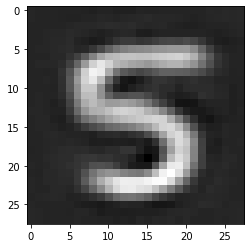

In [170]:
ind=67
pixels=test_output['recon'][ind]
plt.imshow(pixels, cmap='gray')
plt.show()

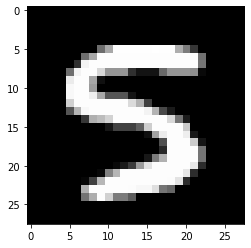

In [171]:
plt.imshow(test_img[ind], cmap='gray')
plt.show()

In [156]:
test_img[0].max()

2.8214867

In [190]:
img,target=next(iter(test_loader))
img,target = img[0:1].cuda(),target[0:1].cuda()

In [191]:
probs=classifier(img)['probs']

In [193]:
mu,_=vae.encoder(img,probs)

In [194]:
vae.decoder(mu,probs)

tensor([[[[-0.3943, -0.4118, -0.4080, -0.4150, -0.4302, -0.4337, -0.4447,
           -0.4470, -0.4557, -0.4117, -0.4273, -0.4083, -0.4127, -0.4040,
           -0.3876, -0.4062, -0.4042, -0.3791, -0.3956, -0.4038, -0.4006,
           -0.3864, -0.4057, -0.3857, -0.3911, -0.3890, -0.3840, -0.3758],
          [-0.3920, -0.4078, -0.4146, -0.4284, -0.4394, -0.4509, -0.4528,
           -0.4308, -0.3903, -0.3458, -0.3408, -0.3646, -0.4148, -0.4000,
           -0.4480, -0.4277, -0.4261, -0.4327, -0.3836, -0.3749, -0.3716,
           -0.3710, -0.3855, -0.3694, -0.3909, -0.3821, -0.3873, -0.3753],
          [-0.3948, -0.4248, -0.4091, -0.4274, -0.4357, -0.4434, -0.4577,
           -0.4139, -0.3588, -0.3002, -0.3629, -0.4350, -0.4797, -0.4596,
           -0.4288, -0.4355, -0.4432, -0.4272, -0.4117, -0.4253, -0.3684,
           -0.3631, -0.3453, -0.3412, -0.3931, -0.4132, -0.4147, -0.4000],
          [-0.4204, -0.4123, -0.4053, -0.4243, -0.4476, -0.4219, -0.4537,
           -0.3706, -0.3564, -0.358